In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.8.0
tiktoken version: 0.11.0


In [3]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [4]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [7]:
import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])
print("Total number of tokens:", len(preprocessed))

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
Total number of tokens: 4690


In [9]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
vocab = {token:integer for integer,token in enumerate(all_words)}

print(vocab_size)

1130


In [ ]:
#### print first 50 items in vocab      
# for i, item in enumerate(vocab.items()):
#     print(item)
#     if i >= 50:
#         break

In [12]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab #1 Stores the vocabulary as a class attribute for access in the encode and decode methods
        self.int_to_str = {i:s for s,i in vocab.items()} #2 Creates an inverse vocabulary that maps token IDs back to their corresponding tokens
    
    def encode(self, text): #3 Processes the input text to convert it into a list of token IDs
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids): #4 Converts a list of token IDs back into the original text
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #5 Removes spaces before the specified puncutation
        return text

In [15]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))
print(tokenizer.decode(tokenizer.encode(text)))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [18]:
####It's useful to add some "special" tokens for unknown words and to denote the end of a text
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}
len(vocab.items())
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [ ]:

###We also need to adjust the tokenizer accordingly so that it knows when and how to use the new <unk> token

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [21]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))


Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## 2.5 BytePair encoding
2.5 BytePair encoding
- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: https://github.com/openai/gpt-2/blob/master/src/encoder.py
- In this chapter, we are using the BPE tokenizer from OpenAI's open-source tiktoken library, which implements its core algorithms in Rust to improve computational performance

In [23]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))
tokenizer = tiktoken.get_encoding("gpt2")

text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)
strings = tokenizer.decode(integers)

print(strings)

tiktoken version: 0.11.0
[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


## 2.6 Data sampling with a sliding window
We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:
- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [24]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

enc_sample = enc_text[50:]
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

5145
x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [25]:
### One by one, the prediction would look like as follows:

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [27]:
### To make it more interpretable, we can decode the tokens back to strings:

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

    #### We will take care of the next-word prediction in a later chapter after we covered the attention mechanism
#### For now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


**We use a sliding window approach, changing the position by +1:**
----
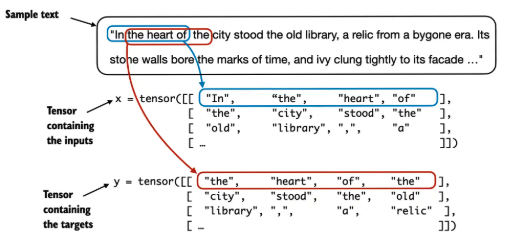

------
Create dataset and dataloader that extract chunks from the input text dataset

In [28]:
import torch
print("PyTorch version:", torch.__version__)
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"}) ##1 Tokenizes the entire text using the provided tokenizer, allowing for special tokens like <|endoftext|>  
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride): ##2 Iterates over the tokenized text using a sliding window, to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self): ##3 Returns the number of input-target pairs in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx): ##4 Returns a single row from the dataset, consisting of an input-target pair
        return self.input_ids[idx], self.target_ids[idx]

PyTorch version: 2.8.0


In [30]:
#### The follwing code uses the GPTDatasetV1 to load the inputs in batches via PyTorch's DataLoader class
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, ### drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training
        num_workers=num_workers ### specifies the number of cpu processes to use for data loading. Using multiple workers can speed up data loading, especially for large datasets
    )

    return dataloader

In [31]:
####Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]



Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting
-----
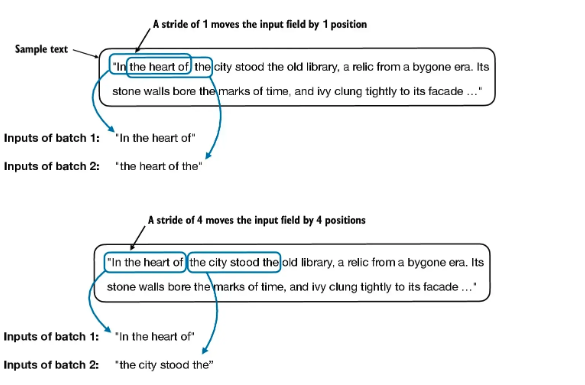

----
Stride equal to the input window size, we can prevent overlaps between batches

In [32]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 Creating token embeddings
- The data is already almost ready for an LLM
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training
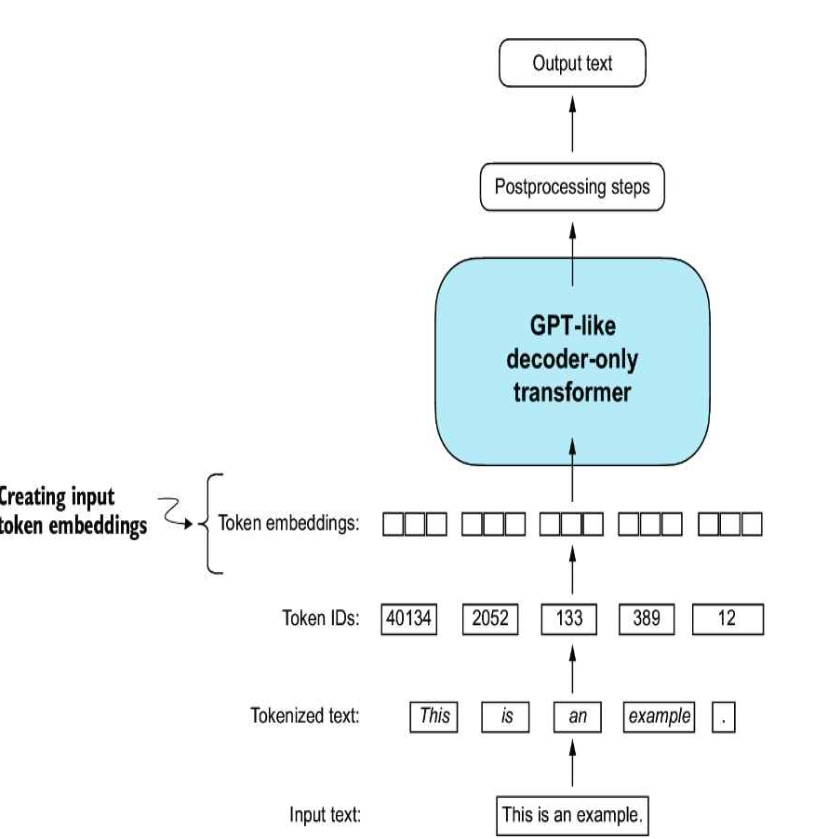
-----
A continuous vector representation, or embedding, is necessary since GPT-like LLMs are deep neural networks trained with the backpropagation algorithm

In [33]:
###Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

print(embedding_layer.weight)


Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described in the supplementary code in ./embedding_vs_matmul
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

An embedding layer is essentially a look-up operation:
You may be interested in the bonus content comparing embedding layers with regular linear layers: ../03_bonus_embedding-vs-matmul
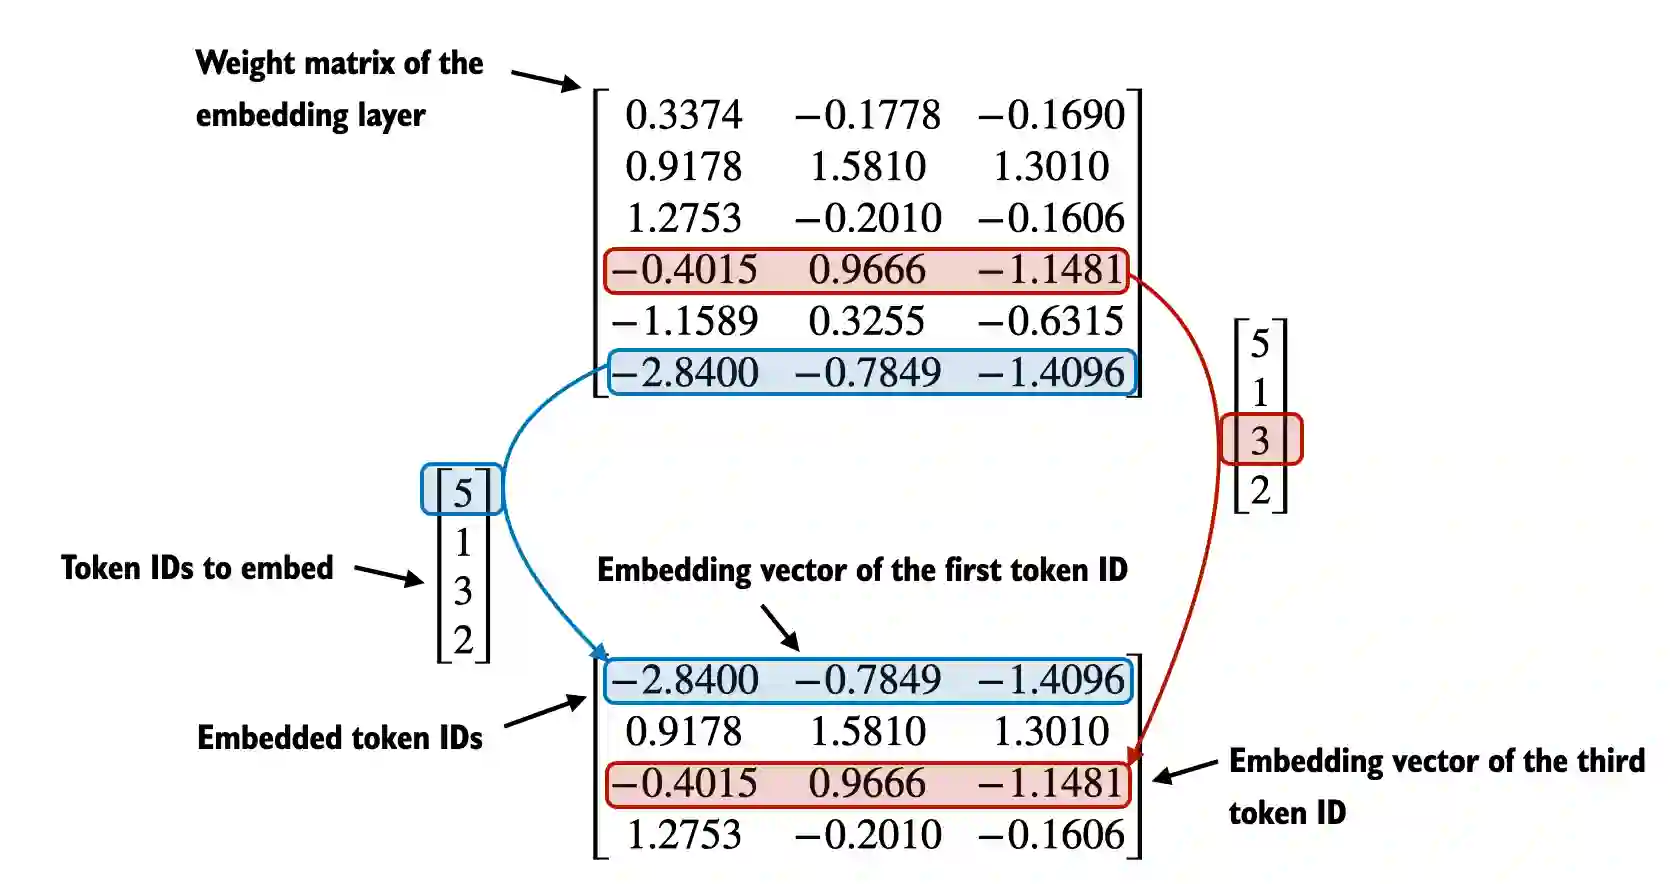

## 2.8 Encoding word positions
Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence
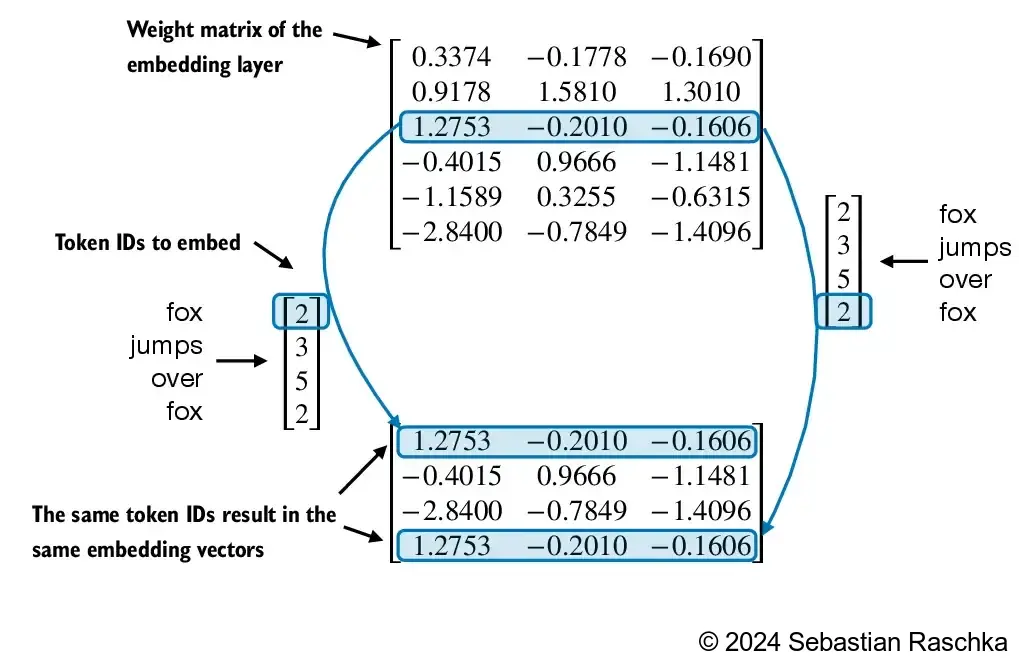
Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:
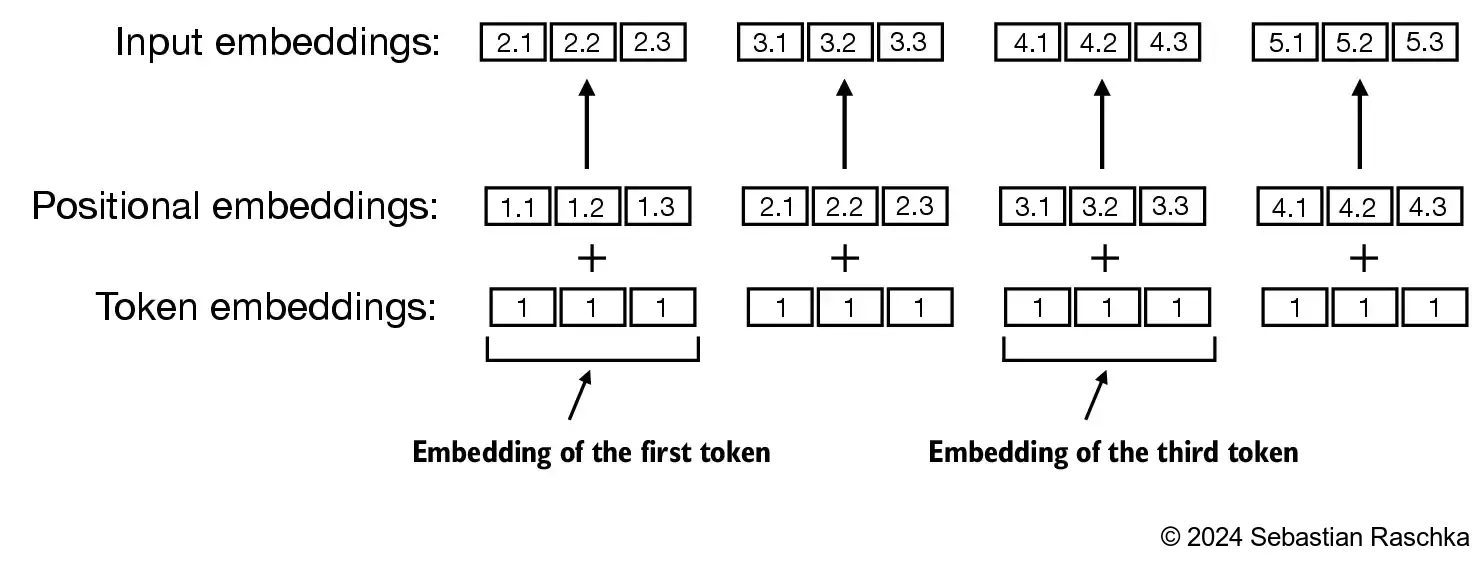

In [34]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(token_embeddings)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
torch.Size([8, 4, 256])


In [35]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(pos_embeddings)

# uncomment & execute the following line to see how the embedding layer weights look like
# print(pos_embedding_layer.weight)
### To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(input_embeddings)

torch.Size([4, 256])
torch.Size([8, 4, 256])


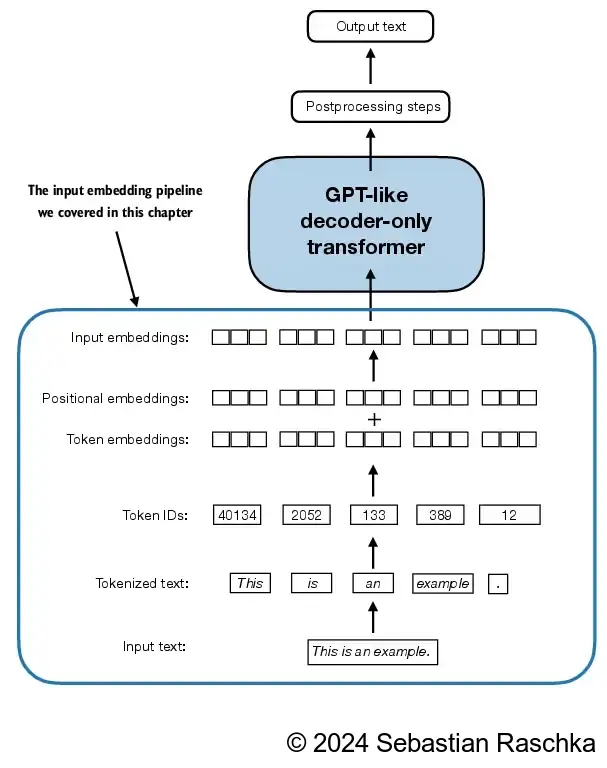